# SIM ARCHIVE: Adaptive RPS algorithm with multiple waves, allocation by boundary uncertainty


In [2]:
import visualizations
from rashomon.hasse import policy_to_profile, enumerate_policies, enumerate_profiles
from rashomon.aggregate import RAggregate
from datagen import (phi_basic, phi_linear_interact, phi_grouped_smooth, phi_grouped_coarse,
                     phi_grouped_smooth2, phi_peak, generate_data_from_assignments)
from allocation import (
    compute_boundary_probabilities, get_prob_allocations,
    create_assignments_from_alloc
)
from rashomon.extract_pools import extract_pools, aggregate_pools
from rashomon.loss import compute_pool_means, compute_policy_means
from rashomon.metrics import make_predictions
from rashomon.extract_pools import lattice_edges

import numpy as np
import matplotlib.pyplot as plt

In [3]:
M = 4  # number of features
R = np.array([3, 3, 4, 2])  # levels per feature
lambda_reg = 0.001  # reg parameter
epsilon = 0.05  # tolerance off MAP
H = np.inf

num_waves = 5
n = [16, 34, 34, 33, 33] # units per wave

sig = 0.2

verbose = True
adaptive = False

top_k = 10
n_preview = 30

num_workers = 2
# sweep parameter until you get an RPS of a large enough size. Change step and max size depending on dimension.
theta_init = 0.01
theta_init_step = 0.005
max_rset_size = 1000  # desired minimum number of feasible combinations

In [4]:
# enumerate all policies and profiles
all_policies = enumerate_policies(M, R)
num_policies = len(all_policies)
profiles, profile_map = enumerate_profiles(M)
num_profiles = len(profiles)

# profile index mappings
policies_profiles = {}
policies_ids_profiles = {}
policies_profiles_masked = {} # the masked policies just hold the active features
for k, profile in enumerate(profiles):
    ids = [i for i, p in enumerate(all_policies) if policy_to_profile(p) == profile]
    policies_ids_profiles[k] = ids
    policies_profiles[k] = [all_policies[i] for i in ids]

    profile_mask = [bool(v) for v in profile]  # t/f map of which features are active
    masked_policies = [tuple([pol[i] for i in range(M) if profile_mask[i]]) for pol in
                       policies_profiles[k]]
    policies_profiles_masked[k] = masked_policies

lattice_edges = lattice_edges(all_policies)

neighbors = {i: [] for i in range(len(all_policies))}
for i, j in lattice_edges:
    neighbors[i].append(j)
    neighbors[j].append(i)  # edges are undirected

In [5]:
# vector of true policy outcomes
oracle_outcomes = np.array([phi_grouped_coarse(p, R) for p in all_policies])

# oracle rank mapped to policy index (so index 0 gives the best policy index)
oracle_rank_to_policy = np.argsort(-oracle_outcomes)

# policy index mapped to oracle rank (so index 0 gives oracle rank for first policy 0)
oracle_policy_to_rank = np.empty_like(oracle_rank_to_policy)
oracle_policy_to_rank[oracle_rank_to_policy] = np.arange(len(oracle_outcomes))

# top-k indices, policies, and values
top_k_indices = oracle_rank_to_policy[:top_k]
top_k_policies = [all_policies[i] for i in top_k_indices]
top_k_values = oracle_outcomes[top_k_indices]

# overview of the rank, index, and profiles of the top policies
if verbose:
    print("Top-k best policies and their profiles:")
    for rank, idx in enumerate(top_k_indices, 1):
        policy = all_policies[idx]
        profile = policy_to_profile(policy)
        print(f"Rank {rank}: Policy idx {idx}, Policy {[int(i) for i in policy]}, Profile {profile}")

Top-k best policies and their profiles:
Rank 1: Policy idx 24, Policy [1, 0, 0, 0], Profile (1, 0, 0, 0)
Rank 2: Policy idx 8, Policy [0, 1, 0, 0], Profile (0, 1, 0, 0)
Rank 3: Policy idx 4, Policy [0, 0, 2, 0], Profile (0, 0, 1, 0)
Rank 4: Policy idx 2, Policy [0, 0, 1, 0], Profile (0, 0, 1, 0)
Rank 5: Policy idx 26, Policy [1, 0, 1, 0], Profile (1, 0, 1, 0)
Rank 6: Policy idx 10, Policy [0, 1, 1, 0], Profile (0, 1, 1, 0)
Rank 7: Policy idx 32, Policy [1, 1, 0, 0], Profile (1, 1, 0, 0)
Rank 8: Policy idx 0, Policy [0, 0, 0, 0], Profile (0, 0, 0, 0)
Rank 9: Policy idx 48, Policy [2, 0, 0, 0], Profile (1, 0, 0, 0)
Rank 10: Policy idx 16, Policy [0, 2, 0, 0], Profile (0, 1, 0, 0)


Trying theta: 0.0100
Theta: 0.0100 -- RPS size: 0
Trying theta: 0.0150
Theta: 0.0150 -- RPS size: 0
Trying theta: 0.0200
Theta: 0.0200 -- RPS size: 0
Trying theta: 0.0250
Theta: 0.0250 -- RPS size: 57
Trying theta: 0.0240
Theta: 0.0240 -- RPS size: 30
Trying theta: 0.0250
Theta: 0.0250 -- RPS size: 57
Trying theta: 0.0260
Theta: 0.0260 -- RPS size: 91
Trying theta: 0.0270
Theta: 0.0270 -- RPS size: 140
Trying theta: 0.0280
Theta: 0.0280 -- RPS size: 197
Trying theta: 0.0290
Theta: 0.0290 -- RPS size: 264
Trying theta: 0.0300
Theta: 0.0300 -- RPS size: 358
Trying theta: 0.0310
Theta: 0.0310 -- RPS size: 453
Trying theta: 0.0320
Theta: 0.0320 -- RPS size: 573
Trying theta: 0.0330
Theta: 0.0330 -- RPS size: 704
Trying theta: 0.0340
Theta: 0.0340 -- RPS size: 822
Trying theta: 0.0350
Theta: 0.0350 -- RPS size: 957
Trying theta: 0.0360
Theta: 0.0360 -- RPS size: 1073
Return for next sweep
Trying theta: 0.0350
Theta: 0.0350 -- RPS size: 957
Trying theta: 0.0352
Theta: 0.0352 -- RPS size: 981

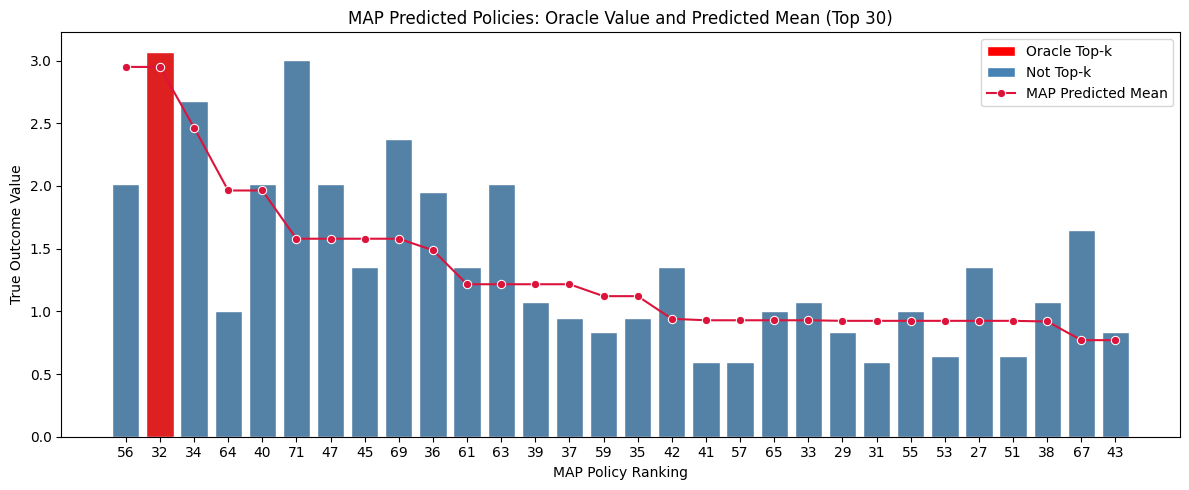

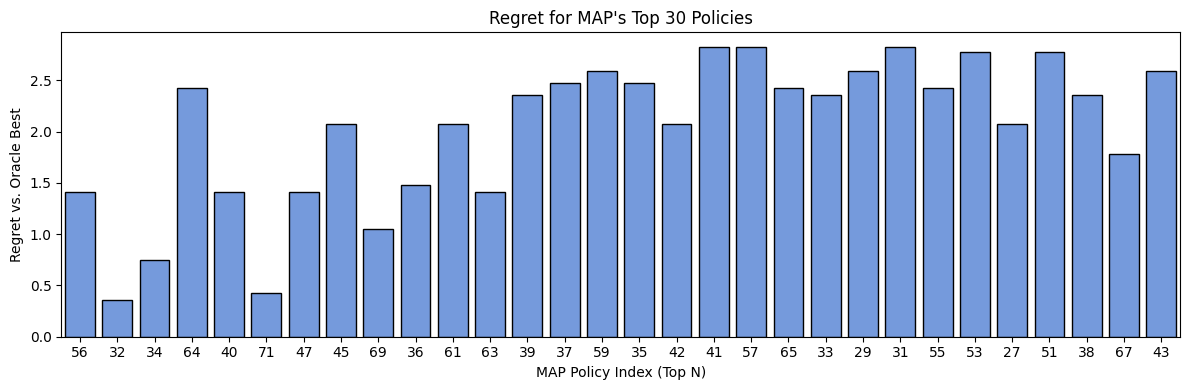

MAP top-30 min regret: 0.356  max regret: 2.828
Regression results: R2 = 0.522, Slope = 0.60, Intercept = 0.49


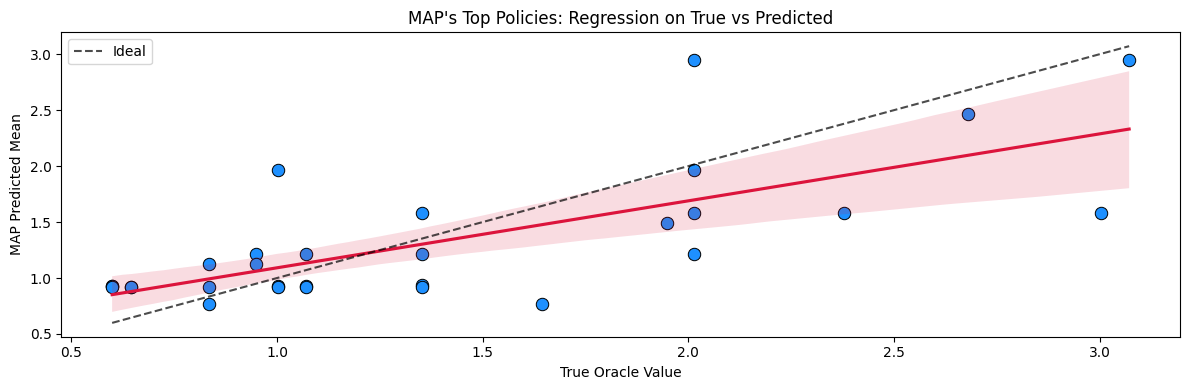

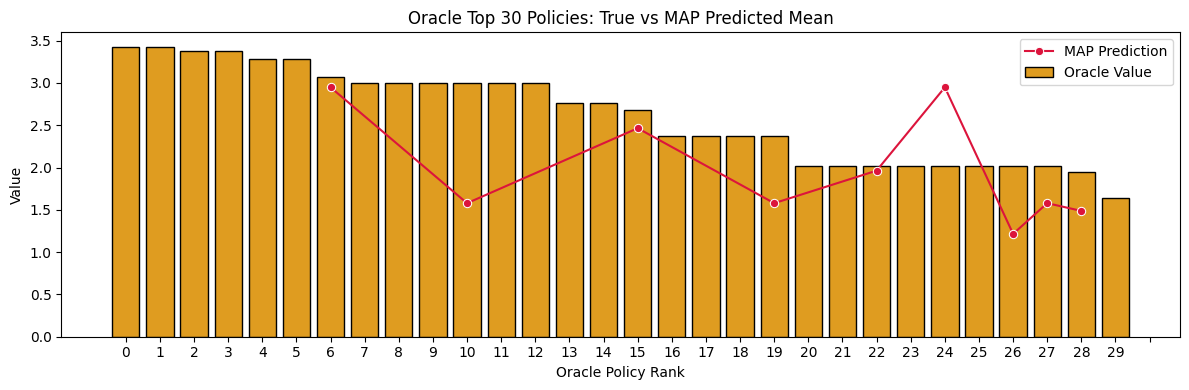

Oracle top-30 min/max regret (MAP predicted minus true): -0.936 / 1.424


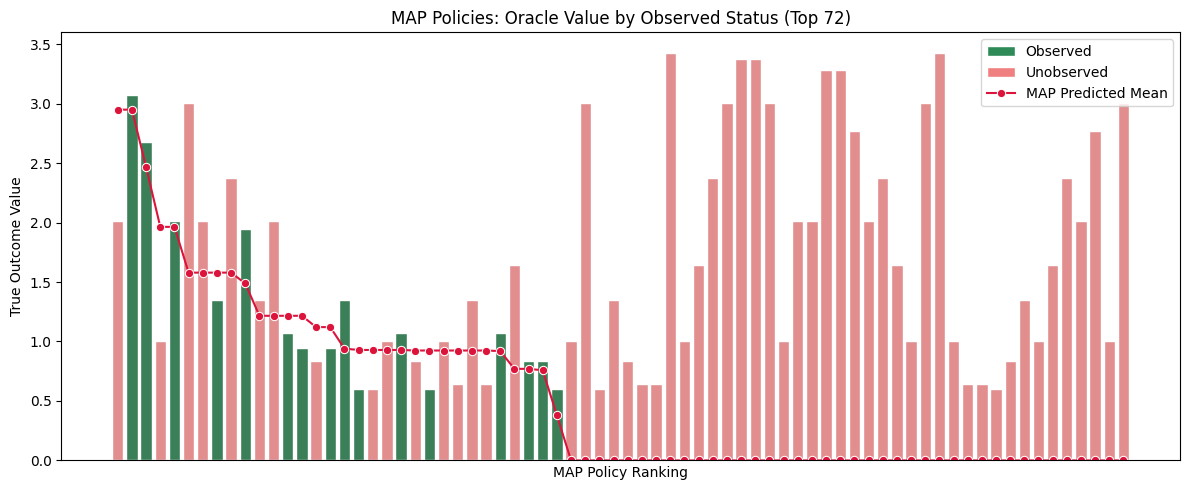

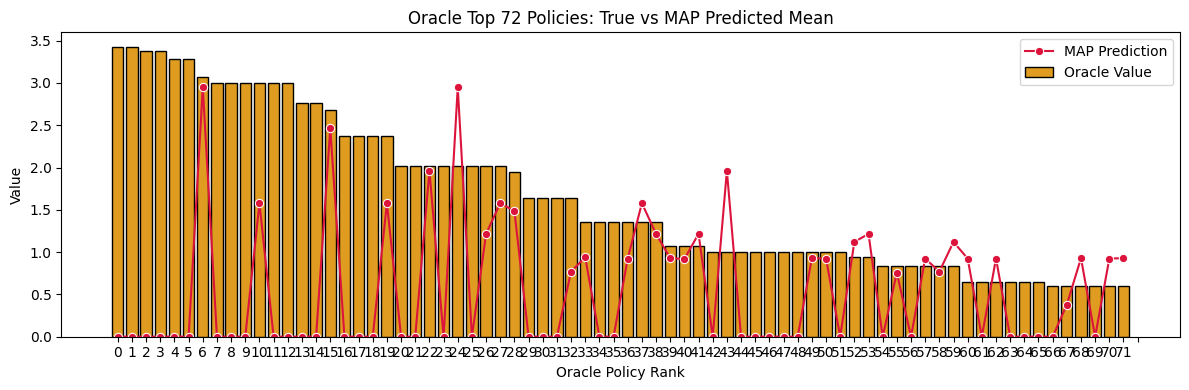

Oracle top-72 min/max regret (MAP predicted minus true): -0.961 / 3.428


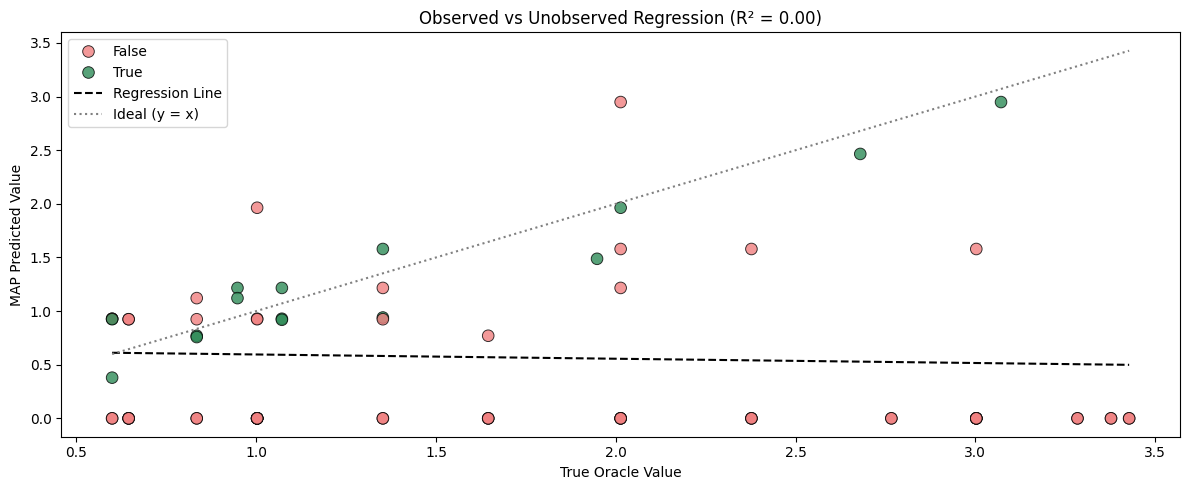

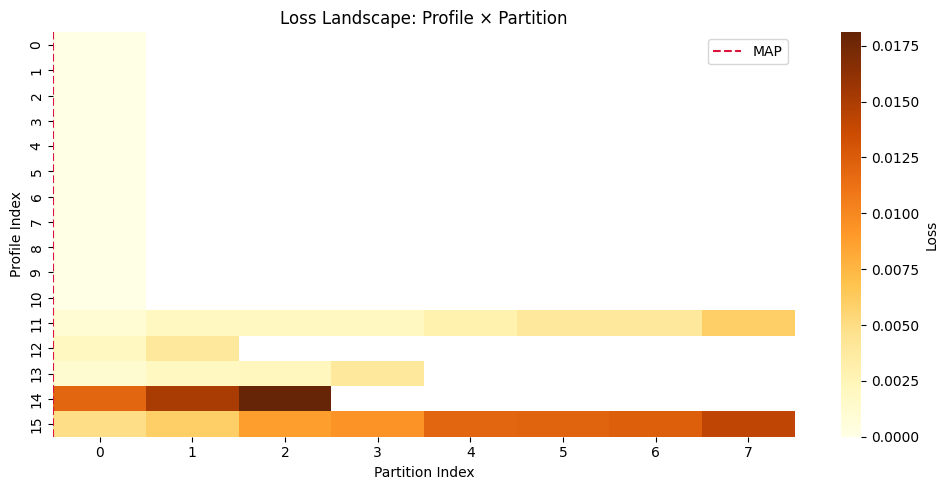

Number of partitions per profile: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 2, 4, 3, 8]
Trying theta: 0.0354
Theta: 0.0354 -- RPS size: 0
Trying theta: 0.0404
Theta: 0.0404 -- RPS size: 28
Trying theta: 0.0394
Theta: 0.0394 -- RPS size: 12
Trying theta: 0.0404
Theta: 0.0404 -- RPS size: 28
Trying theta: 0.0414
Theta: 0.0414 -- RPS size: 58
Trying theta: 0.0424
Theta: 0.0424 -- RPS size: 105
Trying theta: 0.0434
Theta: 0.0434 -- RPS size: 163
Trying theta: 0.0444
Theta: 0.0444 -- RPS size: 233
Trying theta: 0.0454
Theta: 0.0454 -- RPS size: 308
Trying theta: 0.0464
Theta: 0.0464 -- RPS size: 375
Trying theta: 0.0474
Theta: 0.0474 -- RPS size: 442
Trying theta: 0.0484
Theta: 0.0484 -- RPS size: 519
Trying theta: 0.0494
Theta: 0.0494 -- RPS size: 618
Trying theta: 0.0504
Theta: 0.0504 -- RPS size: 776
Trying theta: 0.0514
Theta: 0.0514 -- RPS size: 1021
Return for next sweep
Trying theta: 0.0504
Theta: 0.0504 -- RPS size: 776
Trying theta: 0.0506
Theta: 0.0506 -- RPS size: 819
Trying theta: 0.

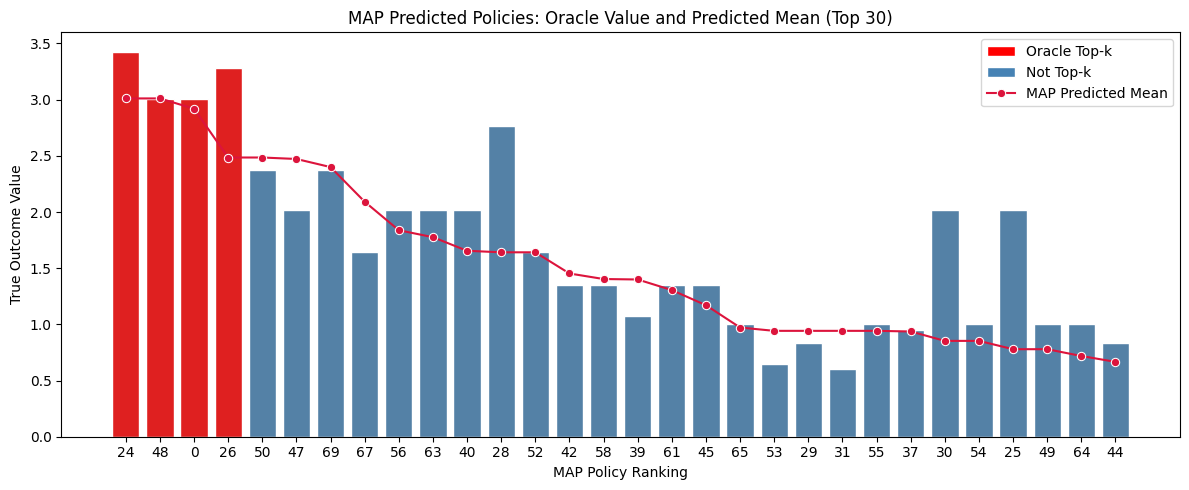

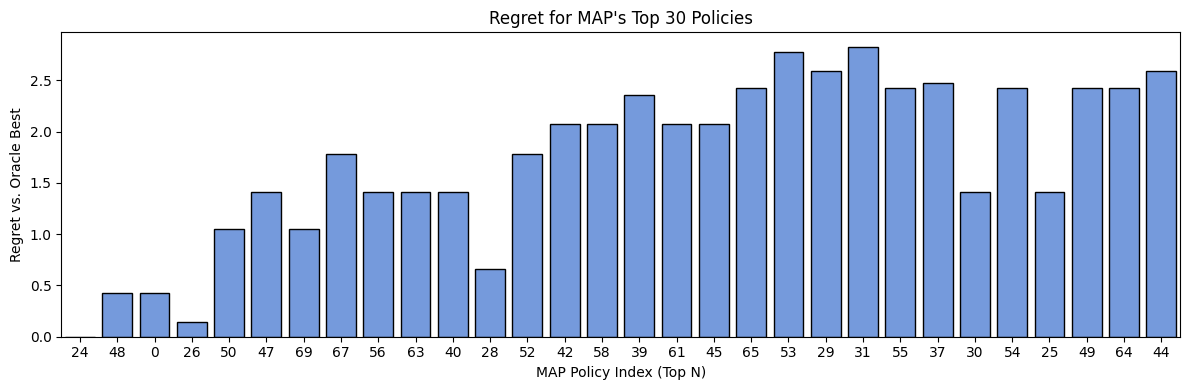

MAP top-30 min regret: 0.000  max regret: 2.828
Regression results: R2 = 0.719, Slope = 0.77, Intercept = 0.24


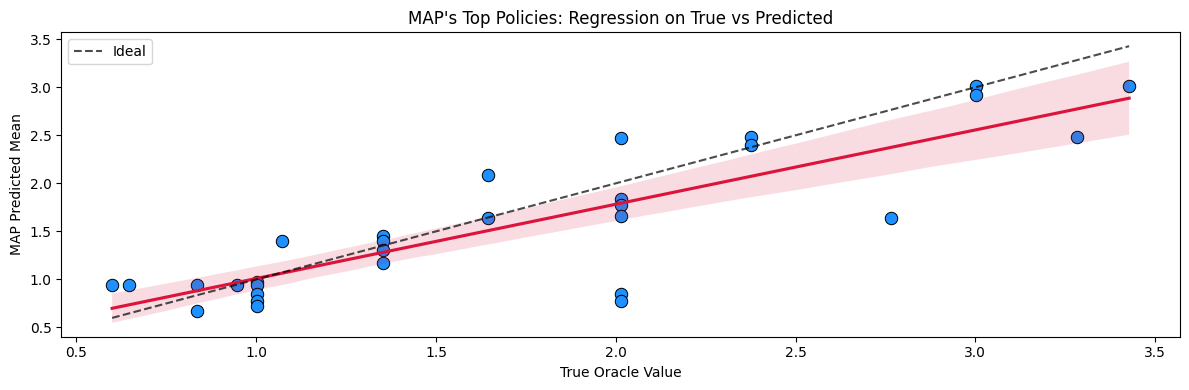

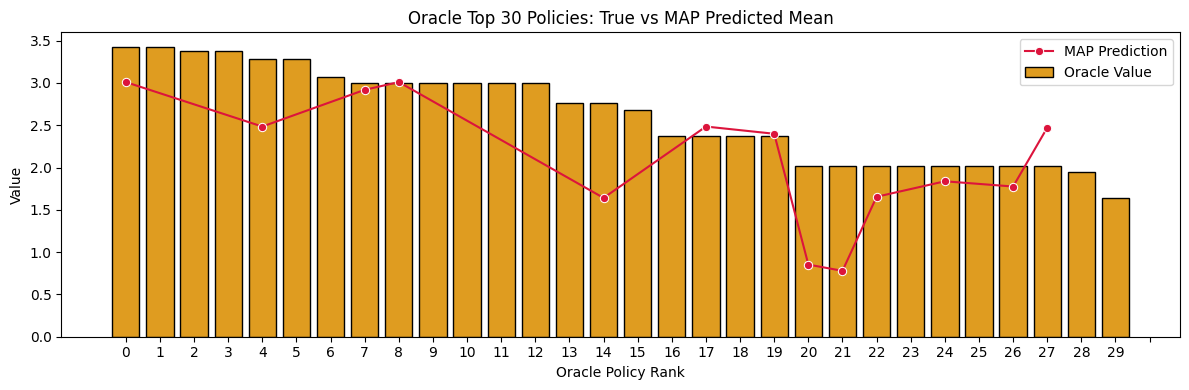

Oracle top-30 min/max regret (MAP predicted minus true): -0.458 / 1.235


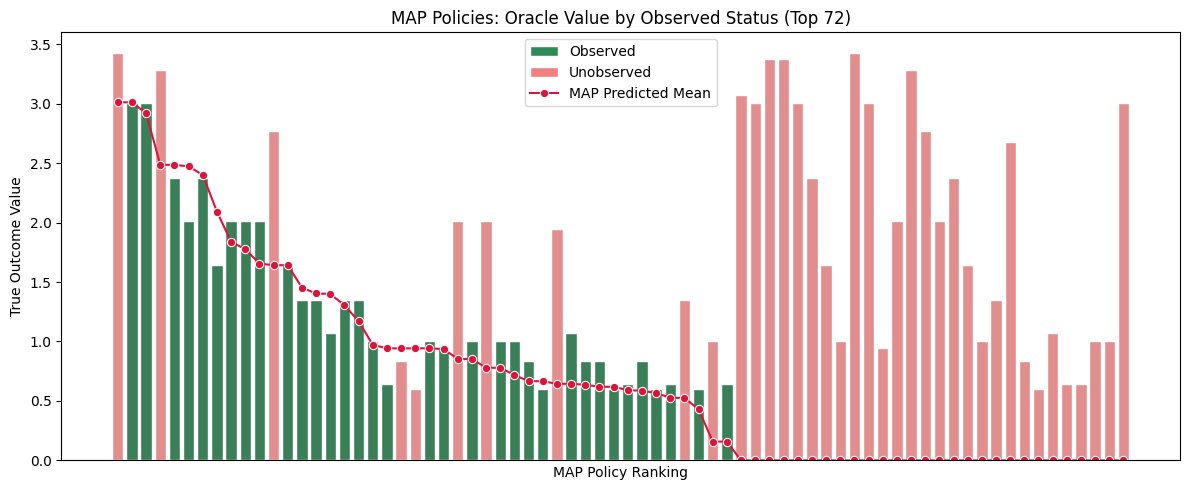

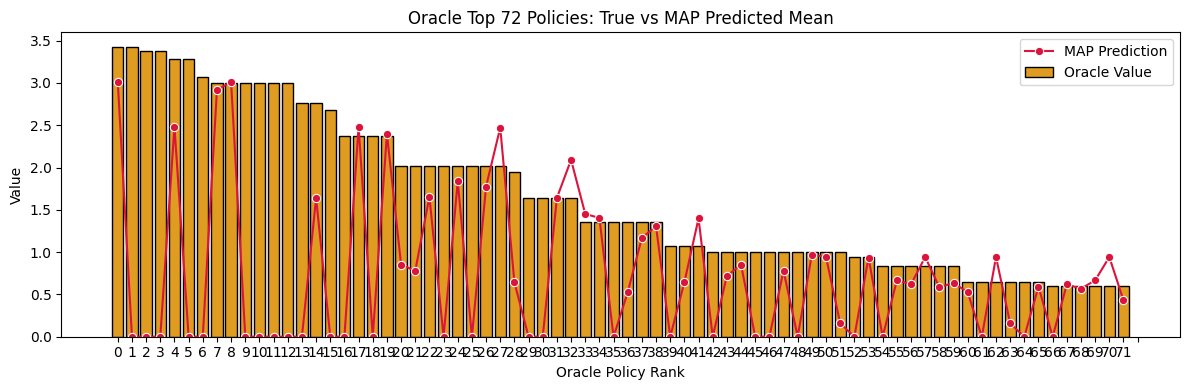

Oracle top-72 min/max regret (MAP predicted minus true): -0.458 / 3.428


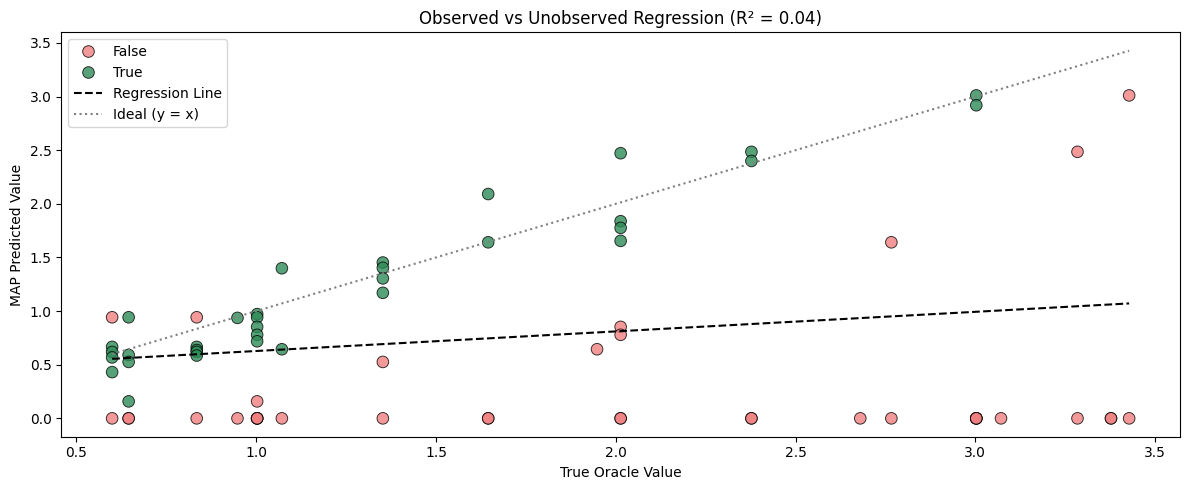

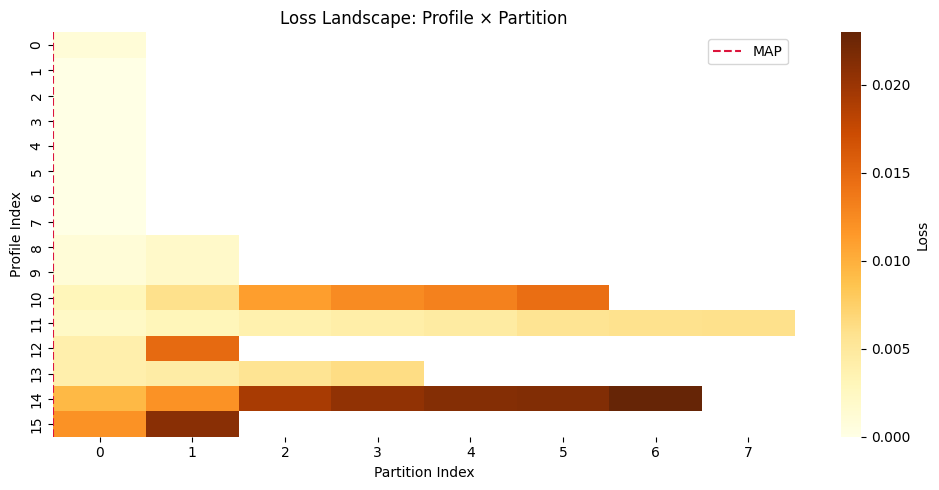

Number of partitions per profile: [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 6, 8, 2, 4, 7, 2]
Trying theta: 0.0514
Theta: 0.0514 -- RPS size: 3357
Return for next sweep
Trying theta: 0.0464
Theta: 0.0464 -- RPS size: 1019
Return for next sweep
Trying theta: 0.0454
Theta: 0.0454 -- RPS size: 650
Trying theta: 0.0456
Theta: 0.0456 -- RPS size: 710
Trying theta: 0.0458
Theta: 0.0458 -- RPS size: 793
Trying theta: 0.0460
Theta: 0.0460 -- RPS size: 871
Trying theta: 0.0462
Theta: 0.0462 -- RPS size: 926
Trying theta: 0.0464
Theta: 0.0464 -- RPS size: 1019
End theta: 0.0464, RPS size: 1019
First-wave Rashomon set: 1019 feasible global partitions (combinations of per-profile poolings).


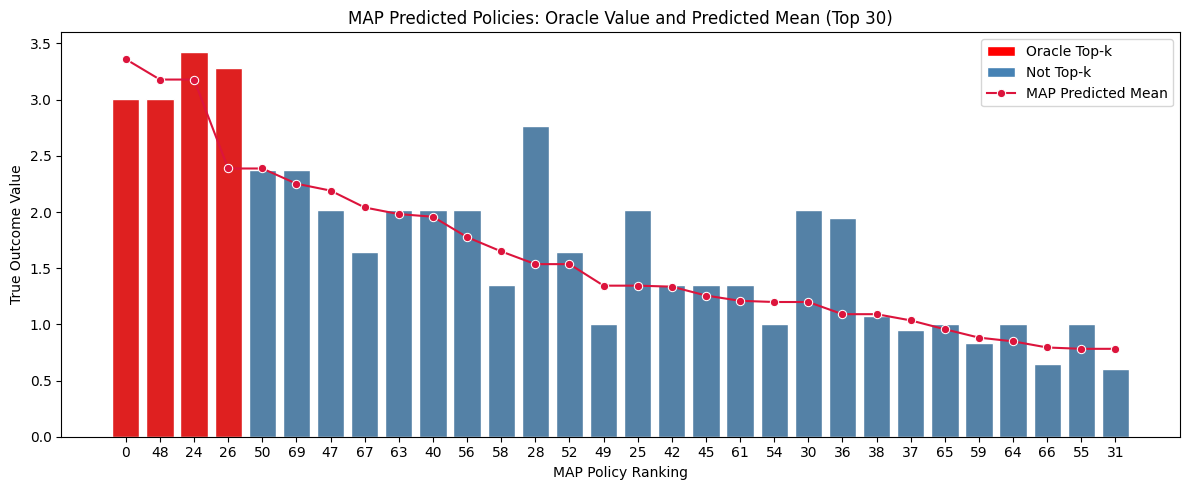

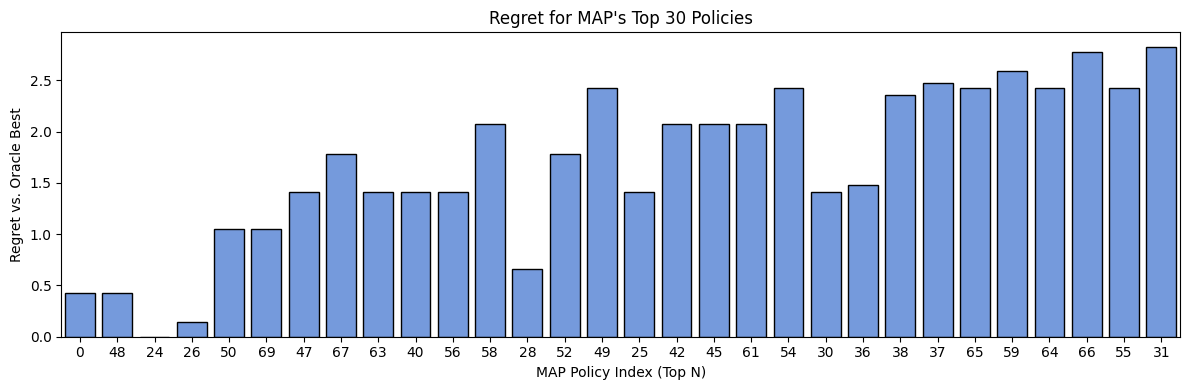

MAP top-30 min regret: 0.000  max regret: 2.828
Regression results: R2 = 0.751, Slope = 0.80, Intercept = 0.23


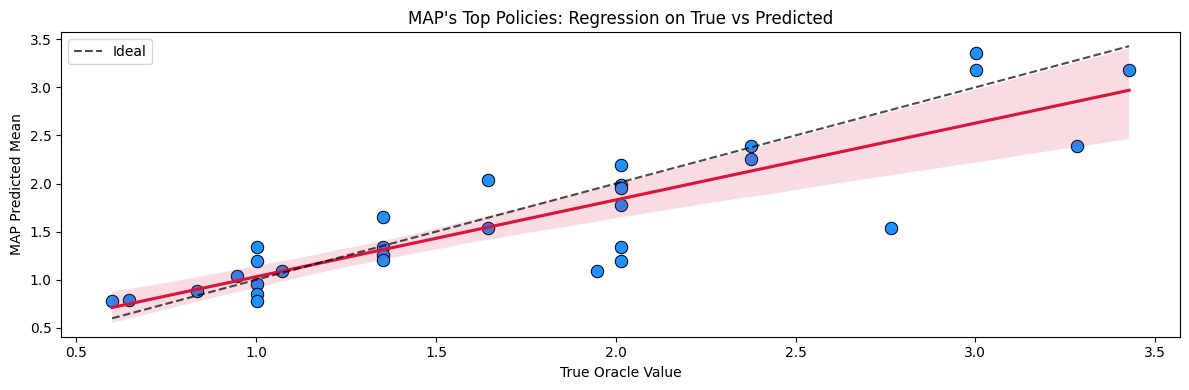

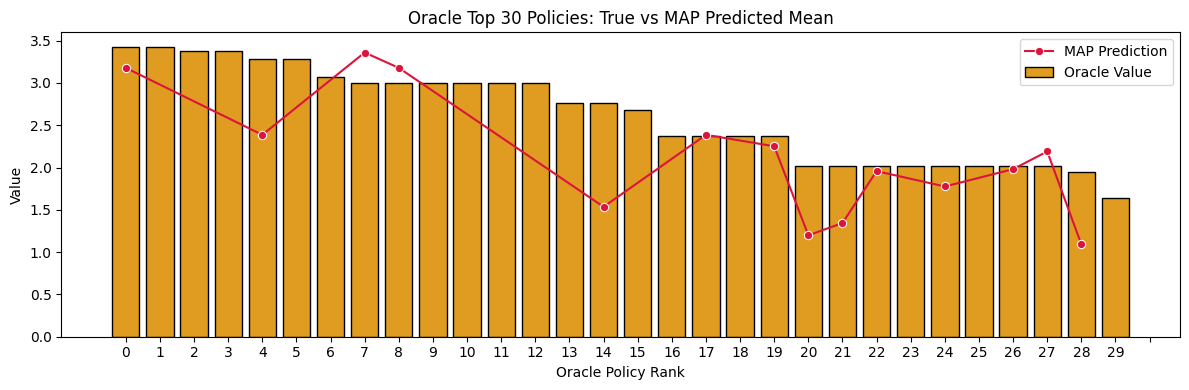

Oracle top-30 min/max regret (MAP predicted minus true): -0.358 / 1.230


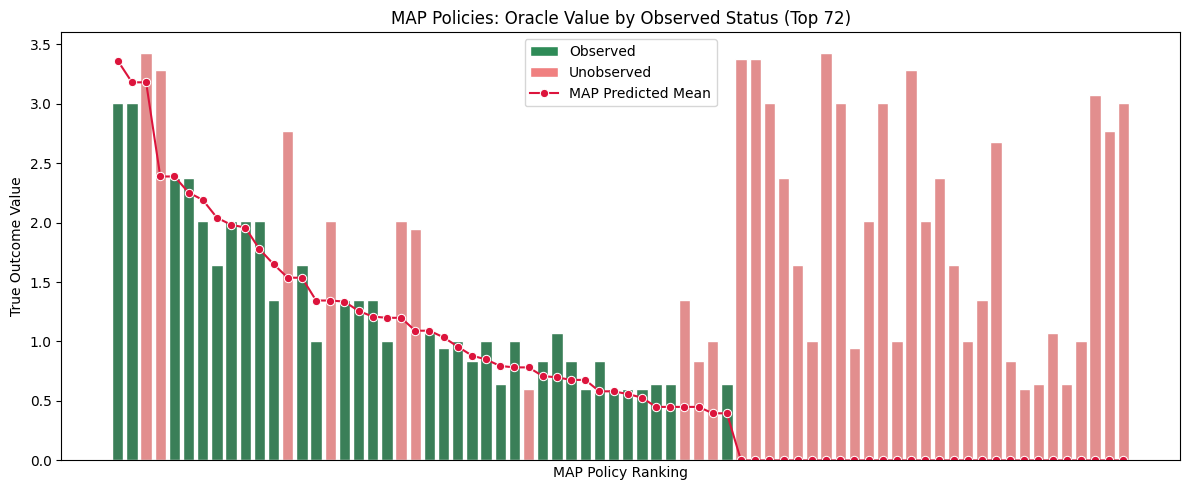

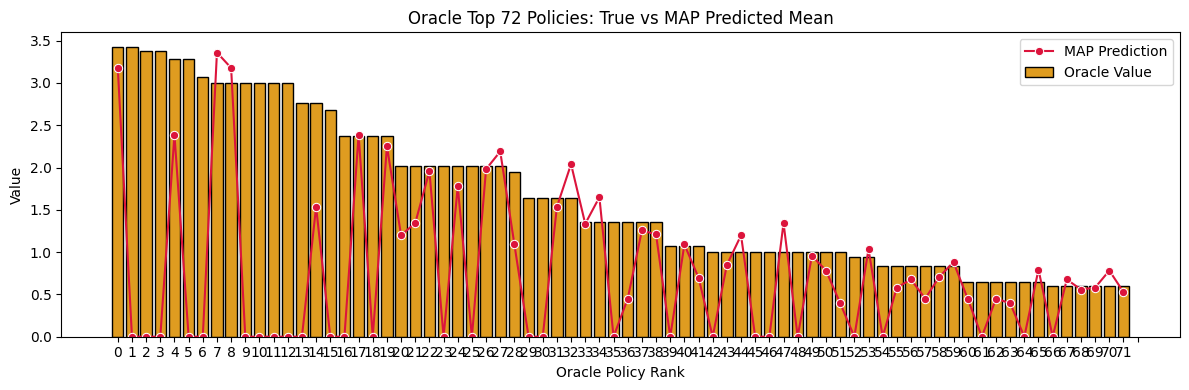

Oracle top-72 min/max regret (MAP predicted minus true): -0.395 / 3.428


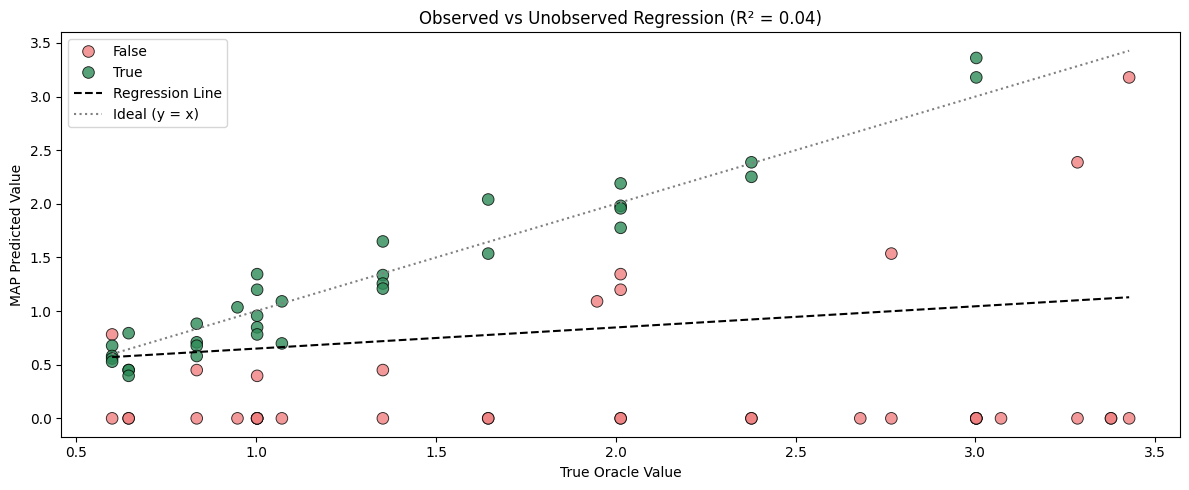

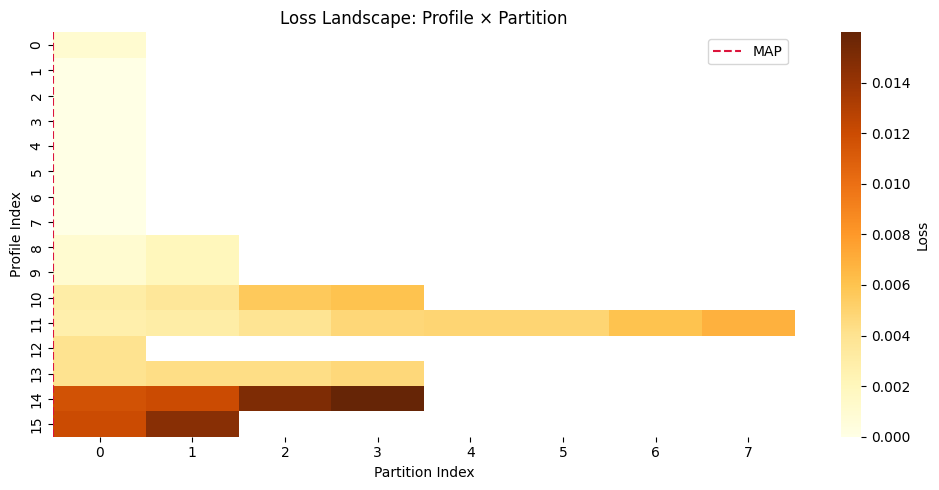

Number of partitions per profile: [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 8, 1, 4, 4, 2]
Trying theta: 0.0464
Theta: 0.0464 -- RPS size: 692
Trying theta: 0.0454
Theta: 0.0454 -- RPS size: 542
Trying theta: 0.0464
Theta: 0.0464 -- RPS size: 692
Trying theta: 0.0474
Theta: 0.0474 -- RPS size: 864
Trying theta: 0.0484
Theta: 0.0484 -- RPS size: 1063
Return for next sweep
Trying theta: 0.0474
Theta: 0.0474 -- RPS size: 864
Trying theta: 0.0476
Theta: 0.0476 -- RPS size: 892
Trying theta: 0.0478
Theta: 0.0478 -- RPS size: 928
Trying theta: 0.0480
Theta: 0.0480 -- RPS size: 982
Trying theta: 0.0482
Theta: 0.0482 -- RPS size: 1021
End theta: 0.0482, RPS size: 1021
First-wave Rashomon set: 1021 feasible global partitions (combinations of per-profile poolings).


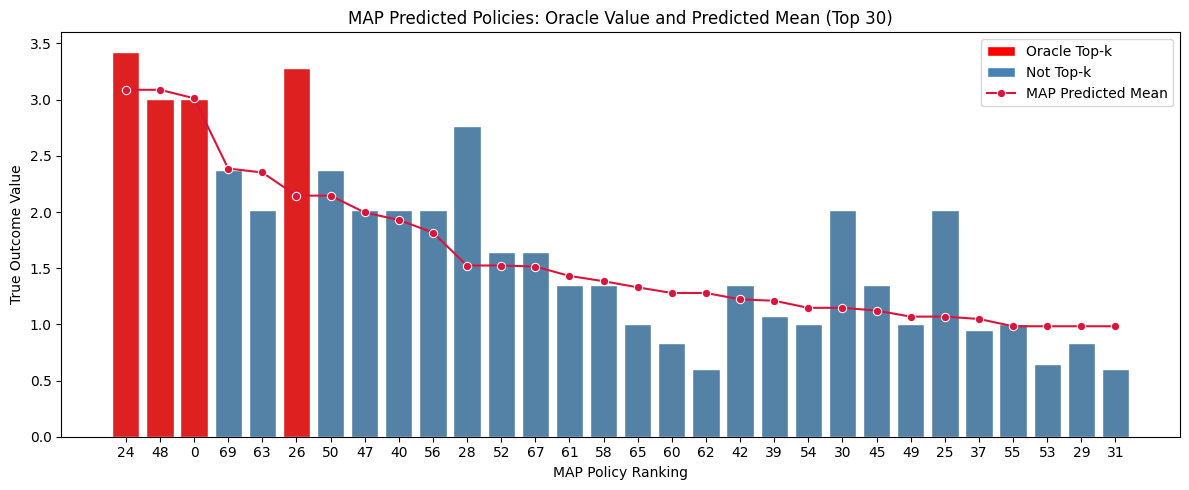

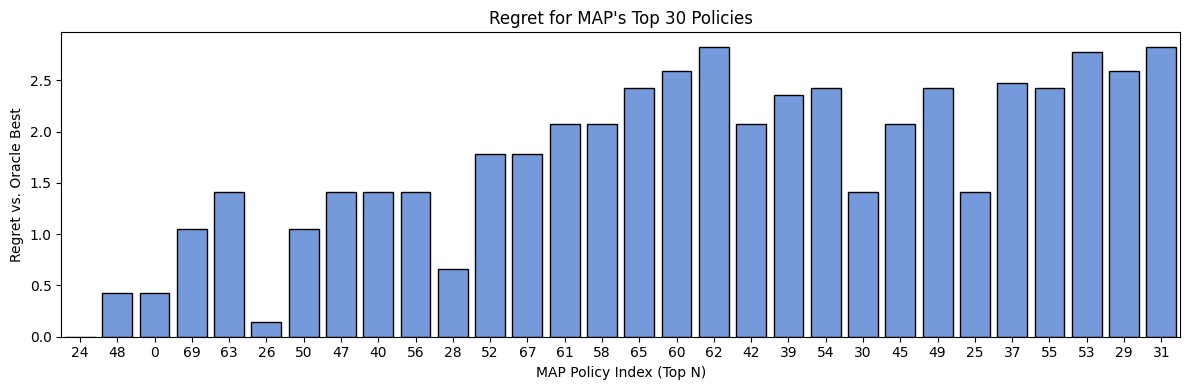

MAP top-30 min regret: 0.000  max regret: 2.828
Regression results: R2 = 0.711, Slope = 0.66, Intercept = 0.50


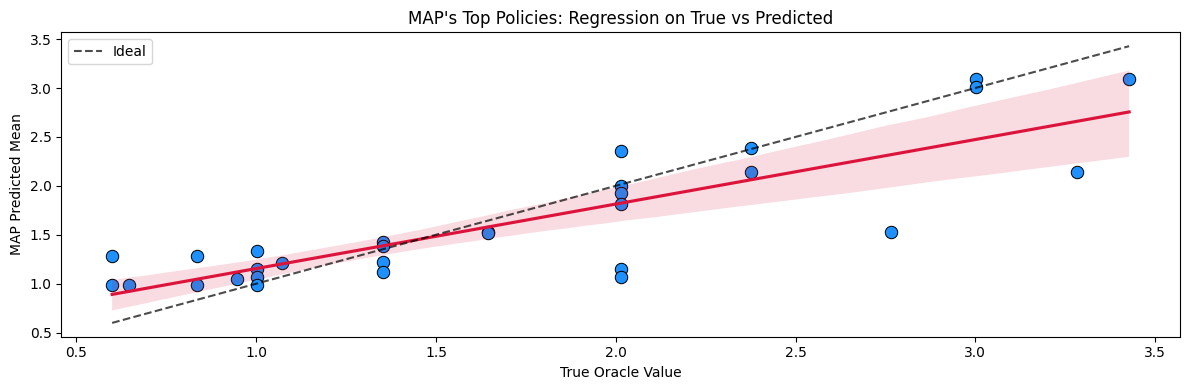

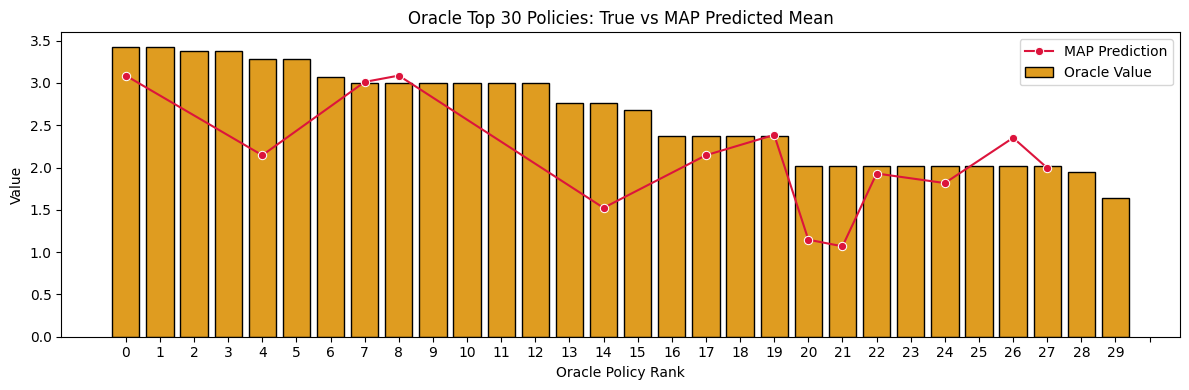

Oracle top-30 min/max regret (MAP predicted minus true): -0.338 / 1.243


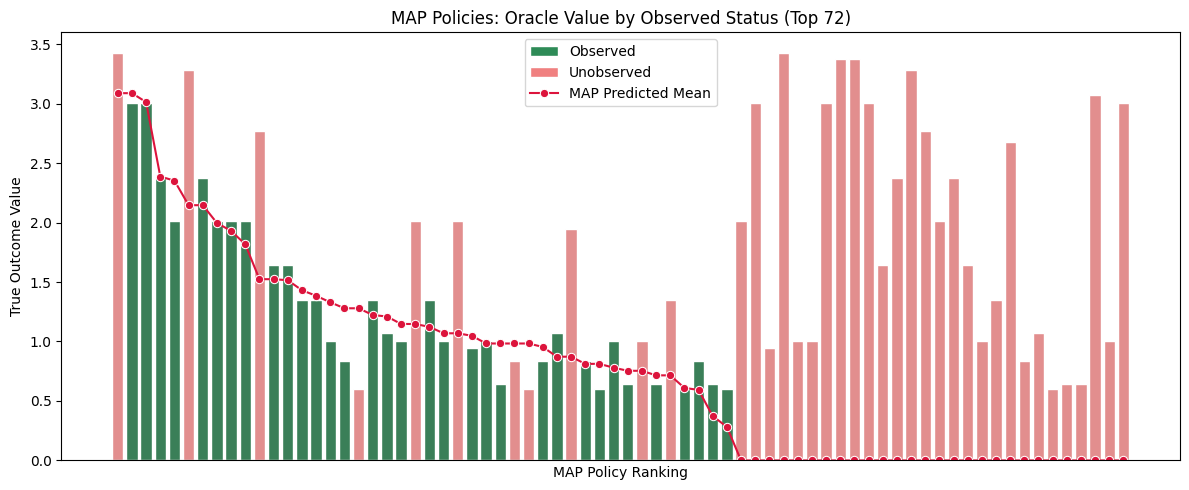

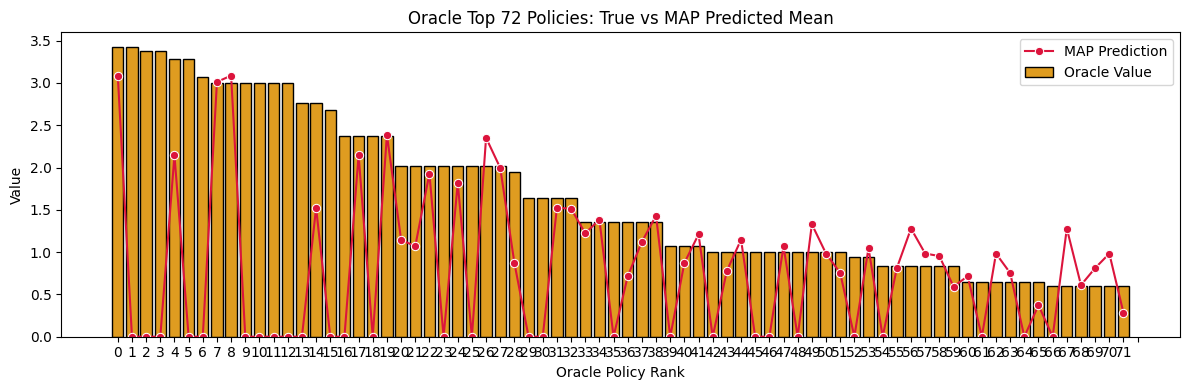

Oracle top-72 min/max regret (MAP predicted minus true): -0.680 / 3.428


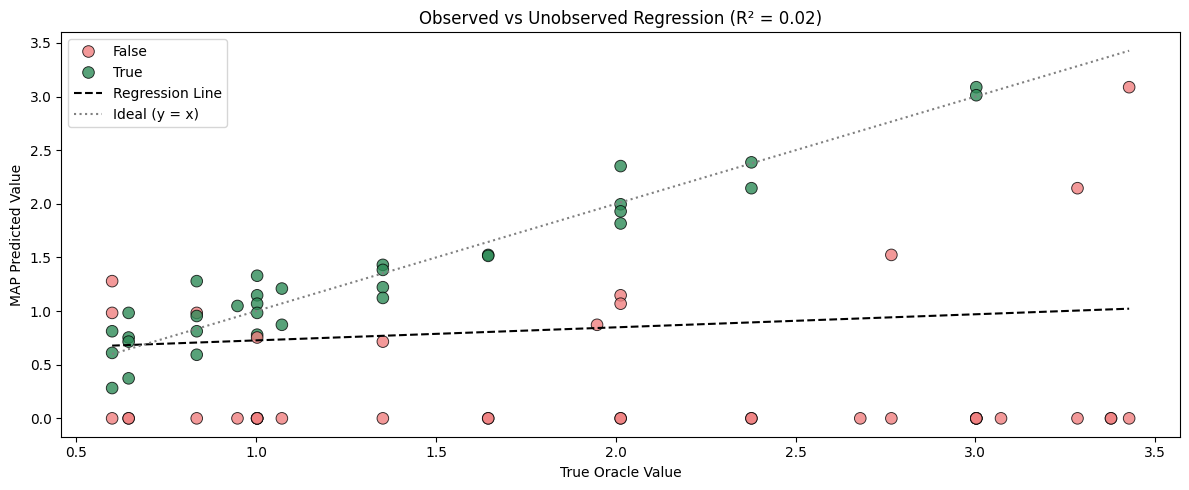

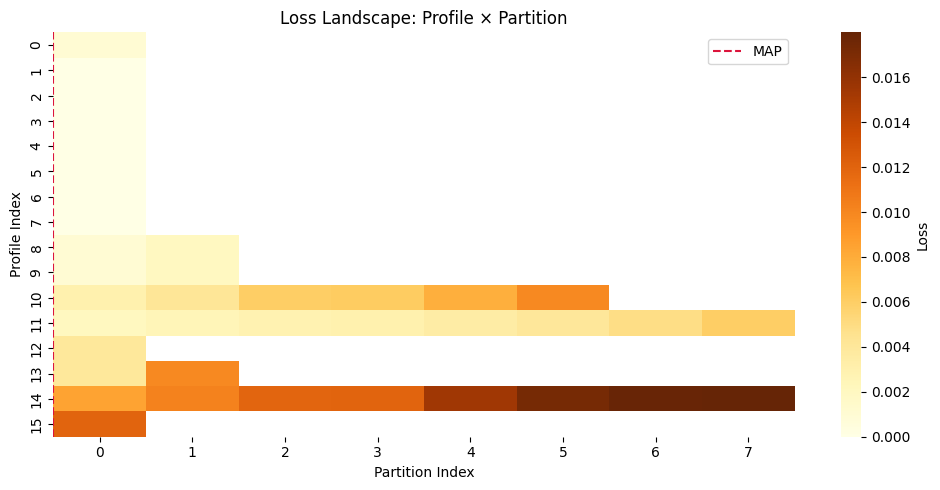

Number of partitions per profile: [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 6, 8, 1, 2, 8, 1]
Trying theta: 0.0482
Theta: 0.0482 -- RPS size: 2259
Return for next sweep
Trying theta: 0.0432
Theta: 0.0432 -- RPS size: 529
Trying theta: 0.0442
Theta: 0.0442 -- RPS size: 761
Trying theta: 0.0452
Theta: 0.0452 -- RPS size: 1062
Return for next sweep
Trying theta: 0.0442
Theta: 0.0442 -- RPS size: 761
Trying theta: 0.0444
Theta: 0.0444 -- RPS size: 824
Trying theta: 0.0446
Theta: 0.0446 -- RPS size: 884
Trying theta: 0.0448
Theta: 0.0448 -- RPS size: 925
Trying theta: 0.0450
Theta: 0.0450 -- RPS size: 994
Trying theta: 0.0452
Theta: 0.0452 -- RPS size: 1062
End theta: 0.0452, RPS size: 1062
First-wave Rashomon set: 1062 feasible global partitions (combinations of per-profile poolings).


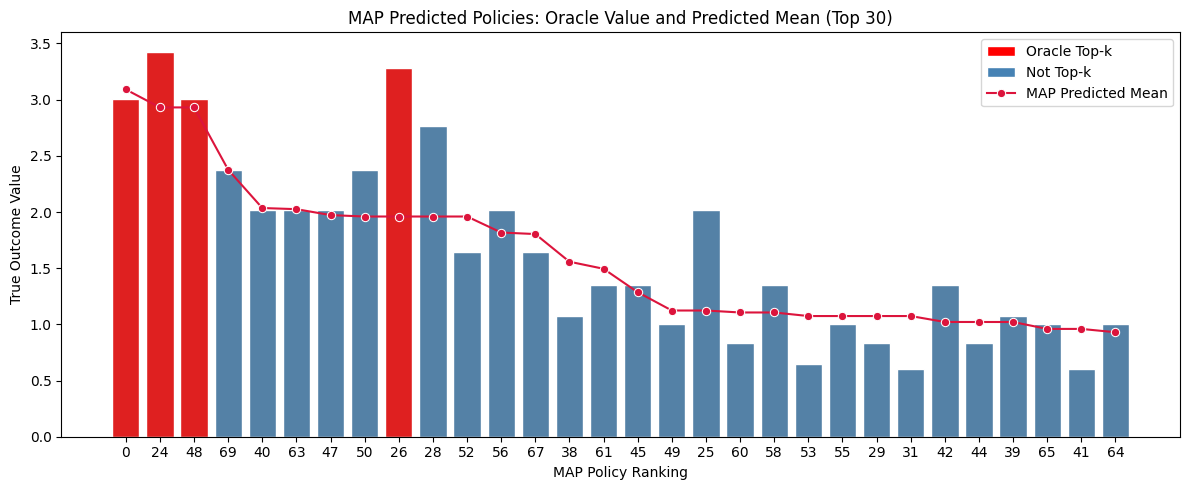

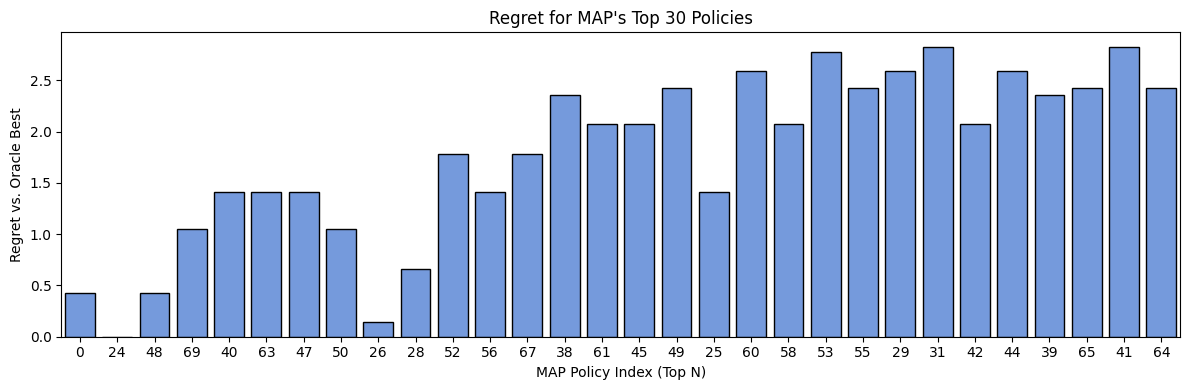

MAP top-30 min regret: 0.000  max regret: 2.828
Regression results: R2 = 0.774, Slope = 0.67, Intercept = 0.48


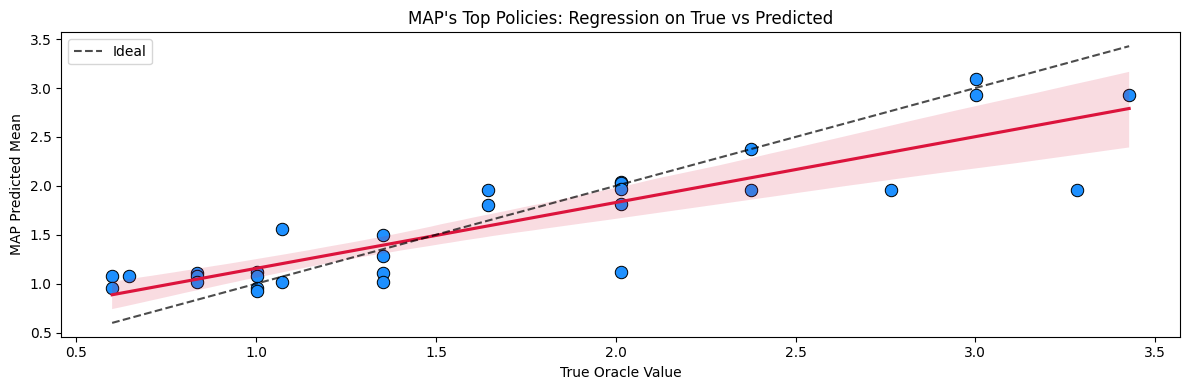

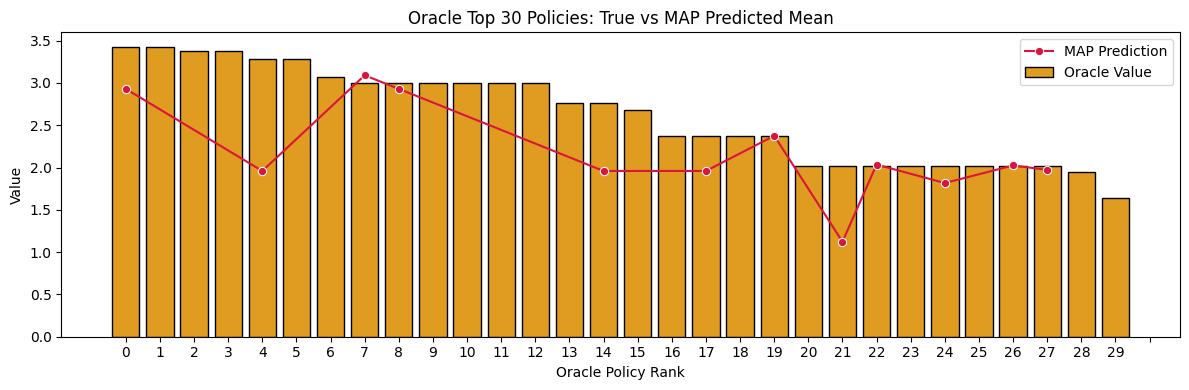

Oracle top-30 min/max regret (MAP predicted minus true): -0.088 / 1.324


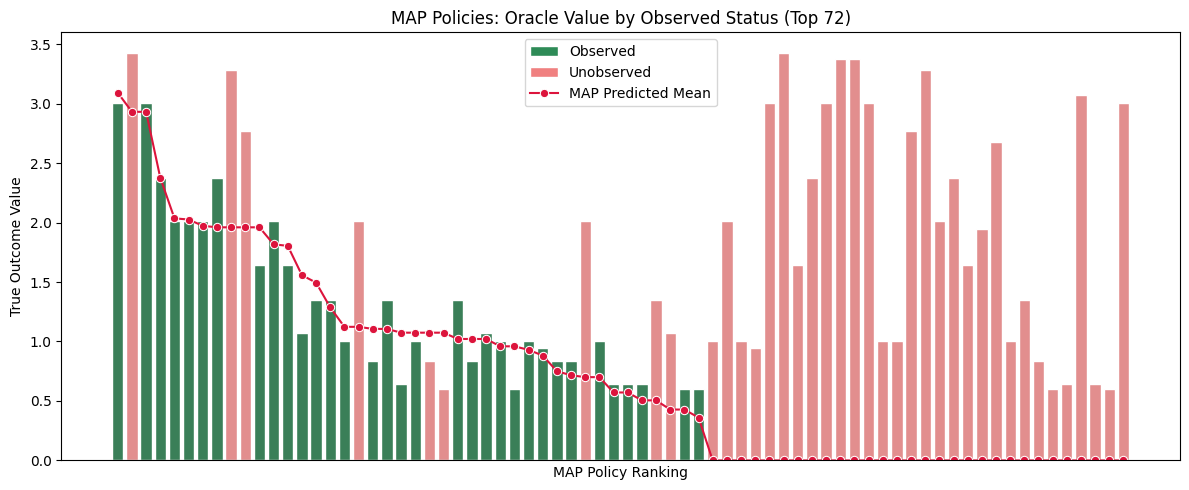

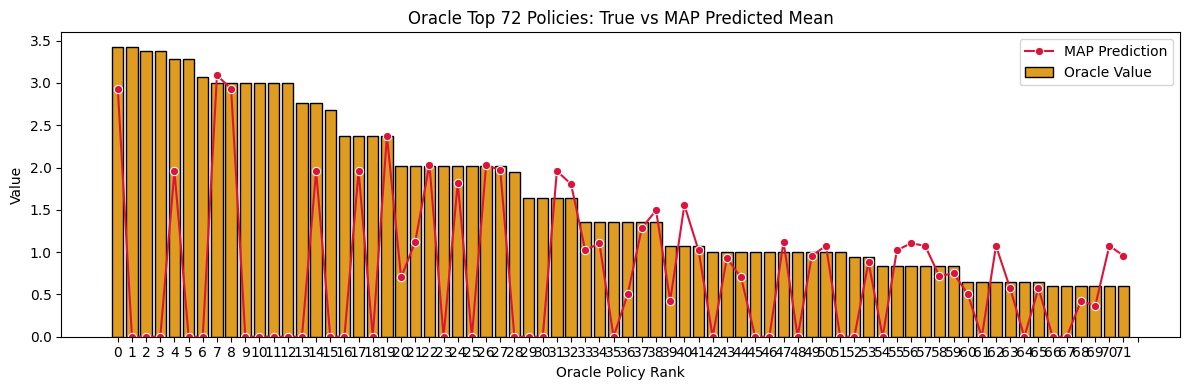

Oracle top-72 min/max regret (MAP predicted minus true): -0.486 / 3.428


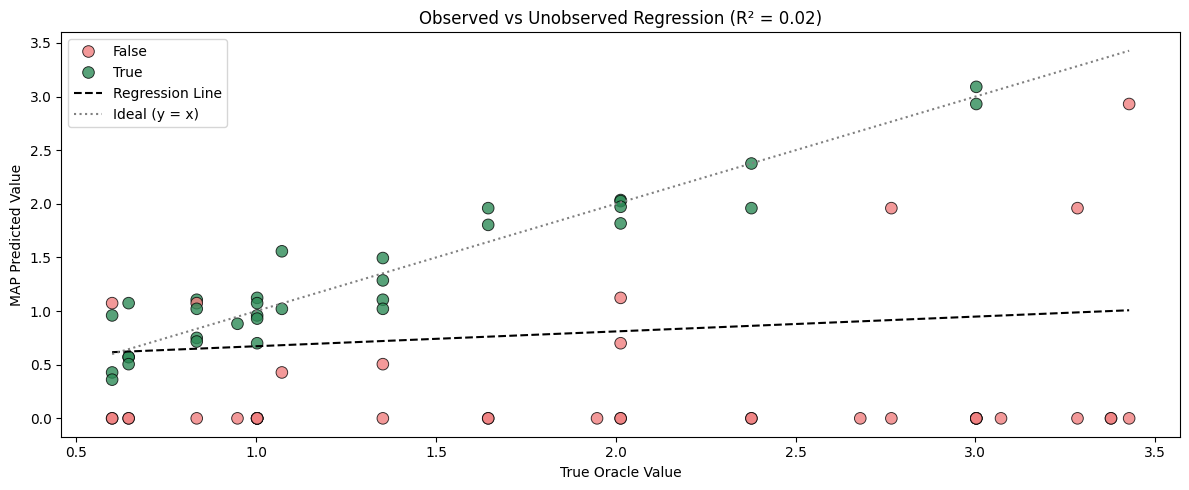

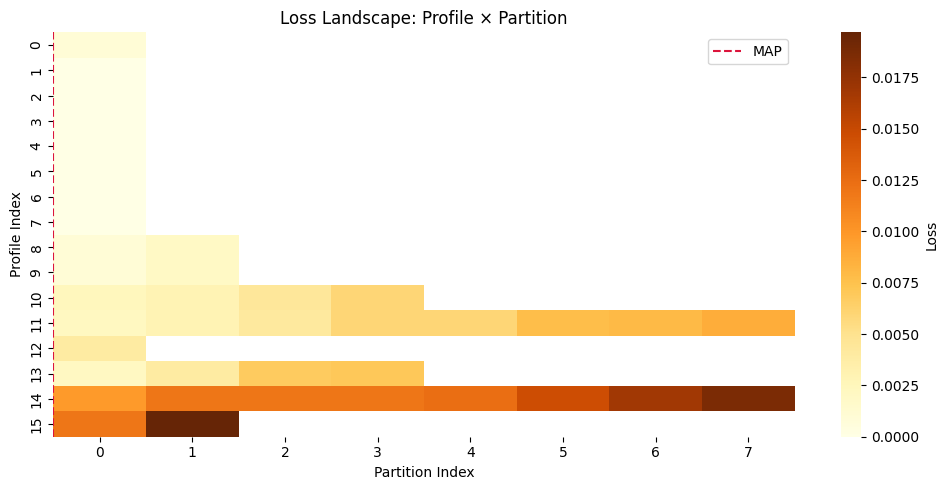

Number of partitions per profile: [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 8, 1, 4, 8, 2]


In [6]:
boundary_probs = np.ndarray(shape=(num_policies,), dtype=float)
metrics_per_wave = []

D_all = np.empty((0, 1), dtype=int)
y_all = np.empty((0, 1), dtype=float)

for wave_number in range(1, num_waves+1):
    np.random.seed(wave_number)
    if wave_number == 1: boundary_probs = compute_boundary_probabilities(all_policies, R, H)
    alloc = get_prob_allocations(boundary_probs, n[wave_number - 1])
    assert(alloc.sum() == n[wave_number-1])
    D_wave = create_assignments_from_alloc(alloc) # shape (n1, 1)
    X_wave, y_wave = generate_data_from_assignments(D_wave, all_policies, oracle_outcomes, sig=sig)

    # Accumulate full data so far
    D = np.vstack([D_all, D_wave])
    y = np.vstack([y_all, y_wave])

    policy_stats = compute_policy_means(D, y, num_policies)

    observed_policy_indices = np.where(policy_stats[:, 1] > 0)[0]
    unobserved_policy_indices = np.where(policy_stats[:, 1] == 0)[0]
    observed_profiles = {
    k for k, ids in policies_ids_profiles.items()
    if np.any(policy_stats[ids, 1] > 0)
    }
    unobserved_profiles = set(policies_ids_profiles.keys()) - observed_profiles

    observed_policies_per_profile = {
    k: list(set(ids) & set(observed_policy_indices))
    for k, ids in policies_ids_profiles.items()
    }

    policy_observation_density = {
        k: len(observed_policies_per_profile.get(k, [])) / len(policies_ids_profiles[k])
        for k in policies_ids_profiles
    }

    if wave_number == 1:
        theta = theta_init
        theta_step = theta_init_step

    max_steps = 50
    steps = 0
    num_sweeps = 3
    for sweep in range(num_sweeps):
        steps = 0
        while steps < max_steps:
            if verbose:
                print(f"Trying theta: {theta:.4f}")
            R_set, R_profiles = RAggregate(
                M, R, H, D, y, theta,
                reg=lambda_reg, num_workers=num_workers, verbose=False
            )
            if verbose:
                print(f"Theta: {theta:.4f} -- RPS size: {len(R_set)}")
            if len(R_set) >= max_rset_size and sweep < num_sweeps - 1:
                print(f"Return for next sweep")
                theta -= theta_step
                theta_step = theta_step / 5
                break
            if len(R_set) >= max_rset_size and sweep == num_sweeps - 1:
                # keep same theta for next wave, but bring the step up in size
                theta_step = theta_step * (5**(num_sweeps-1))
                break
            if len(R_set) > 0 and sweep == 0:
                theta_step /= 5
                theta-=theta_step
                break
            theta += theta_step
            steps += 1

    if len(R_set) == 0:
        print("Warning: No feasible Rashomon set found within range.")
    elif verbose:
        print(f"End theta: {theta:.4f}, RPS size: {len(R_set)}")
        print(f"First-wave Rashomon set: {len(R_set)} feasible global partitions (combinations of per-profile poolings).")

    # Initialization
    num_partitions = len(R_set)
    boundary_matrix = np.zeros((num_partitions, num_policies), dtype=int)

    regrets = []
    best_pred_indices_all = []
    policy_indices_all = []
    policy_means_all = []

    sorted_idx_all = []
    sorted_means_all = []

    partition_losses = np.zeros(num_partitions)

    posterior_mse = []
    posterior_best_mse = []
    posterior_iou = []

    pi_policies_r_list = []
    pool_means_r_list = []

    # track pools for each profile k, for each rashomon set r
    for r, r_set in enumerate(R_set):
        pi_policies_profiles_r = {}

        for k, profile in enumerate(profiles):
            sigma_k = R_profiles[k].sigma[r_set[k]]
            if sigma_k is None:
                # the entire profile is just one pool, so we map all policies to single pool 0.
                n_policies_profile = len(policies_profiles_masked[k])
                pi_policies_r_k = {i: 0 for i in range(n_policies_profile)}
            else:
                _, pi_policies_r_k = extract_pools(policies_profiles_masked[k], sigma_k)

            # each profile (0-indexed) holds a dictionary of each of the included policies (locally 0-indexed, can be remapped with helpers), and indicates assignment to local pool number
            pi_policies_profiles_r[k] = pi_policies_r_k

        # aggregate into global partition structures
        pi_pools_r, pi_policies_r = aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
        pool_means_r = compute_pool_means(policy_stats, pi_pools_r)

        pi_policies_r_list.append(pi_policies_r)
        pool_means_r_list.append(pool_means_r)

        # Partition loss
        partition_losses[r] = sum(R_profiles[k].loss[r_set[k]] for k in range(len(r_set)))

        # Predictions by policy
        policy_indices = np.array(list(pi_policies_r.keys()))
        policy_means = np.array([pool_means_r[pi_policies_r[idx]] for idx in policy_indices])
        order = np.argsort(-policy_means)
        sorted_idx = policy_indices[order]
        sorted_means = policy_means[order]

        # Store results
        policy_indices_all.append(policy_indices)
        policy_means_all.append(policy_means)
        sorted_idx_all.append(sorted_idx)
        sorted_means_all.append(sorted_means)

        best_pred = sorted_idx[0]
        regret = float(oracle_outcomes[top_k_indices[0]] - oracle_outcomes[best_pred])
        regrets.append(regret)
        best_pred_indices_all.append(best_pred)

        # Posterior-weighted metrics
        y_r_est = make_predictions(D, pi_policies_r, pool_means_r)
        mse = np.mean((y_r_est - y) ** 2)

        best_mse = (oracle_outcomes[top_k_indices[0]] - oracle_outcomes[best_pred]) ** 2
        iou = len(set(sorted_idx[:top_k]) & set(top_k_indices)) / len(set(sorted_idx[:top_k]) | set(top_k_indices))

        posterior_mse.append(mse)
        posterior_best_mse.append(best_mse)
        posterior_iou.append(iou)

        # Boundary structure
        for i in range(num_policies):
            pool_i = pi_policies_r.get(i, -1)
            count = 0
            for nb in neighbors[i]:
                pool_nb = pi_policies_r.get(nb, -1)
                if pool_nb != -1 and pool_nb != pool_i:
                    count += 1
            boundary_matrix[r, i] = count

    # Posterior weights and expected metrics
    posterior_weights = np.exp(-partition_losses)
    posterior_weights /= posterior_weights.sum() if posterior_weights.sum() > 0 else 1.0
    map_idx = np.argmin(partition_losses)
    map_loss = partition_losses[map_idx]

    policy_indices = policy_indices_all[map_idx]
    policy_means = policy_means_all[map_idx]
    order = np.argsort(-policy_means)

    sorted_idx = sorted_idx_all[map_idx]
    sorted_means = sorted_means_all[map_idx]
    oracle_values = oracle_outcomes[sorted_idx]
    oracle_ranks = oracle_policy_to_rank[sorted_idx]
    is_topk = [i in top_k_indices for i in sorted_idx]

    expected_mse = np.dot(posterior_weights, posterior_mse)
    expected_best_mse = np.dot(posterior_weights, posterior_best_mse)
    expected_iou = np.dot(posterior_weights, posterior_iou)
    expected_regret = np.dot(posterior_weights, regrets)

    # get T/F mask of the matrix of counts of number of boundaries
    binary_boundary_matrix = (boundary_matrix > 0).astype(float)
    boundary_probs = np.average(binary_boundary_matrix, axis=0, weights=posterior_weights)
    boundary_probs = np.round(boundary_probs, decimals=8)

    metrics_per_wave.append({
        "wave": wave_number,
        "theta": theta,
        "rps_size": len(R_set),
        "expected_regret": expected_regret,
        "expected_mse": expected_mse,
        "expected_best_mse": expected_best_mse,
        "expected_iou": expected_iou,
        "map_loss": map_loss
    })

    if verbose:
        # MAP Summary and regret plots --
        df_map = visualizations.plot_map_true_vs_predicted_bar_topk(
            sorted_idx=sorted_idx,
            sorted_means=sorted_means,
            oracle_beta=oracle_outcomes,
            oracle_ranks=oracle_policy_to_rank,
            top_k_indices=top_k_indices,
            N=n_preview
        )
        visualizations.plot_map_regret_bar(sorted_idx, oracle_outcomes, top_k_indices[0], N=n_preview)
        visualizations.plot_map_regression(df_map)
        visualizations.plot_oracle_ordered_bar(df_map, top_k_indices, oracle_outcomes, all_policies, N=n_preview)

        df_map_obs = visualizations.plot_map_true_vs_predicted_bar_observed(sorted_idx, sorted_means, oracle_outcomes, oracle_ranks, observed_policy_indices, N=num_policies)
        visualizations.plot_oracle_ordered_bar(df_map_obs, top_k_indices, oracle_outcomes, all_policies, N=num_policies)
        visualizations.plot_map_regression_observed(df_map_obs)

        profile_losses = [rp.loss for rp in R_profiles]
        visualizations.plot_minimax_risk_matrix(profile_losses, map_idx=map_idx)
        print(f"Number of partitions per profile: {[len(p) for p in profile_losses]}")